<H3>На данном шаге проведем анализ выборки, добавим необходимую информацию

Также произведем разбиение на группы ОКПД по заданю</H3>

In [1]:
# Устанавливаем необходимые библиотеки
!pip install -q wordcloud nltk numpy scikit-learn pymorphy2

In [2]:
from tqdm import tqdm

In [3]:
# Данный код удалит переменные из глобальной видимости для сохранения свободного ОЗУ =)


# Просто для вашего понимания
'''
to_keep = ['df']  # список переменных, которые хотите сохранить

to_delete = [var for var in globals() if var not in to_keep and not var.startswith('_')]
for var in to_delete:
    del globals()[var]
'''

# Аккуратно, он также удаляет импорты =)

"\nto_keep = ['df']  # список переменных, которые хотите сохранить\n\nto_delete = [var for var in globals() if var not in to_keep and not var.startswith('_')]\nfor var in to_delete:\n    del globals()[var]\n"

In [4]:
# Необходимые библиотеки
import re
from collections import defaultdict

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from wordcloud import WordCloud

import pymorphy2
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk import FreqDist

In [5]:
# Отключаем предупреждения. Мы знаем, что делаем
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Загрузим необходимые расширения
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

True

In [7]:
# Названия столбцов
COLUMNS = ['Номер', 'Исполнитель', 'Заказчик',
           'Район', 'Заказ', 'Тип бюджета',
           'Цена контракта', 'Начало контракта', 'Конец контракта',
           'Описание y', 'y']

# Папка для сохранения фото
PHOTO_FOLDER = 'images/'

In [8]:
# Читаем файл, созданный на шаге 1, задаем корректные названия столбцов
df = pd.read_csv('datasets/new.csv',
                 encoding="utf-8", low_memory=False)

df.columns = COLUMNS

# Анализ и преобразование данных

Рассмотрим поближе данные, при необходимости преобразуем

## Информация

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13930734 entries, 0 to 13930733
Data columns (total 11 columns):
 #   Column            Dtype  
---  ------            -----  
 0   Номер             int64  
 1   Исполнитель       object 
 2   Заказчик          object 
 3   Район             object 
 4   Заказ             object 
 5   Тип бюджета       object 
 6   Цена контракта    float64
 7   Начало контракта  object 
 8   Конец контракта   object 
 9   Описание y        object 
 10  y                 float64
dtypes: float64(2), int64(1), object(8)
memory usage: 1.1+ GB


In [10]:
# Вместо head лучше выводить случайный набор из 5 строк, так будет чуть репрезентативнее
df.sample(n=5).T

,9135919,4004427,10188744,4538896,13238123
Номер,3503807939017000016,3860201761618000029,3910206791717000002,3760701209521000003,2771433860922004906
Исполнитель,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ \ПРЕД...,ШАМАНАЕВА ВАЛЕРИЯ ПАВЛОВНА,ИЛЬЯСОВ ЛЕНУР РУСЛАНОВИЧ,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ \КАНЦ...,"АО \САНОФИ РОССИЯ\"""""
Заказчик,"МКУ \УКС\""""","ДЕПАРТАМЕНТ ЖКХ, Э, ТИС АДМИНИСТРАЦИИ СУРГУТСК...","МБДОУ №4 \ЛАСТОЧКА\"" Г. СИМФЕРОПОЛЯ""","МДОУ \ДЕТСКИЙ САД № 19\""""",ГКУ АЗ (КС) ДЗМ
Район,Московская область,Ханты-Мансийский автономный округ - Югра (Тюме...,Республика Крым,Ярославская область,Город Москва столица Российской Федерации горо...
Заказ,Выполнение работ по ремонту полов в актовом за...,Выполнение работ по ликвидации (в том числе в...,Свекла,поставка бумаги для офисной техники белой,Поставка лекарственного препарата (Ивакафтор+Л...
Тип бюджета,бюджет Пенсионного фонда Российской Федерации,местный бюджет,местный бюджет,местный бюджет,бюджет субъекта Российской Федерации
Цена контракта,1041243.0,480800.13,1069.2,22186.81,5343750.72
Начало контракта,2017-09-13,2018-08-17,2017-01-13,2021-07-12,2022-05-27
Конец контракта,2018-01-09,2018-10-08,2017-04-07,2022-01-14,2023-01-06
Описание y,Работы строительные специализированные,"Услуги по сбору, обработке и удалению отходов;...",Продукция и услуги сельского хозяйства и охоты,Бумага и изделия из бумаги,21.2


Сразу видим проблему в описании заказчиков и исполнителей. А именно - присутствие ненужных символов

In [11]:
# Смотрим пустые данные
df.isna().sum()

Номер               0
Исполнитель         0
Заказчик            0
Район               0
Заказ               0
Тип бюджета         0
Цена контракта      0
Начало контракта    0
Конец контракта     0
Описание y          0
y                   0
dtype: int64

Пустых данных в файле нет, можем преобразовать файл для анализа

## Преобразование данных

Преобразования:

* Начало контракта, Конец контракта - datetime
* y - str

In [12]:
df['Начало контракта'] = pd.to_datetime(df['Начало контракта'], errors='coerce').dt.date
df['Конец контракта'] = pd.to_datetime(df['Конец контракта'], errors='coerce').dt.date

In [13]:
df['y'] = df['y'].astype('str')

Для дальнейшей работы необходимо преобразовать слова. Для этого очистим данные в столбцах "заказчик", "исполнитель"

In [15]:
# Используем регулярное выражение для замены нескольких символов
df['Заказчик'] = df['Заказчик'].str.lower().replace('["\\\\]', '', regex=True)
df['Исполнитель'] = df['Исполнитель'].str.lower().replace('["\\\\]', '', regex=True)

In [16]:
# После преобразования дат могли появиться NaN, очистим от них
df.dropna(inplace=True)

## Добавление столбцов

In [17]:
df['Срок'] = df['Конец контракта'] - df['Начало контракта']
df['Срок'] = df['Срок'].apply(lambda x: x.days)

# Теперь столбцы не нужны
del df['Начало контракта']
del df['Конец контракта']

Также номер контракта не нужен при предсказывании, очистим для экономии памяти

In [18]:
del df['Номер']

## Очистка выбросов

In [19]:
df[['Цена контракта', 'Срок']].describe()

,Цена контракта,Срок
count,1.393072e+07,1.393072e+07
mean,3.483871e+06,2.154338e+02
std,1.434120e+08,1.743624e+02
min,0.000000e+00,-4.700000e+01
25%,4.729309e+04,9.400000e+01
50%,1.715116e+05,1.930000e+02
75%,6.703064e+05,3.200000e+02
max,1.425579e+11,6.611400e+04


Видим явные выбросы. Исправим.

Используем межквартильный размах с небольшим "буфером", чтобы захватить больше данных

[Что это](https://wiki.loginom.ru/articles/iqr.html)

In [20]:
# Возьмем сверху 3 десятых квантилей
buffer = 1.1

# Рассчитываем IQR для столбца "Цена контракта"
Q1_price = df['Цена контракта'].quantile(0.25)
Q3_price = df['Цена контракта'].quantile(0.75)
IQR_price = Q3_price - Q1_price

# Рассчитываем IQR для столбца "Срок"
Q1_duration = df['Срок'].quantile(0.25)
Q3_duration = df['Срок'].quantile(0.75)
IQR_duration = Q3_duration - Q1_duration

# Устанавливаем границы для отсечения данных
lower_bound_price = Q1_price - buffer * IQR_price
upper_bound_price = Q3_price + buffer * IQR_price

lower_bound_duration = Q1_duration - buffer * IQR_duration
upper_bound_duration = Q3_duration + buffer * IQR_duration

# Фильтруем данные
df = df[
    (df['Цена контракта'] >= lower_bound_price) & (df['Цена контракта'] <= upper_bound_price) &
    (df['Срок'] >= lower_bound_duration) & (df['Срок'] <= upper_bound_duration)
]

# Графики

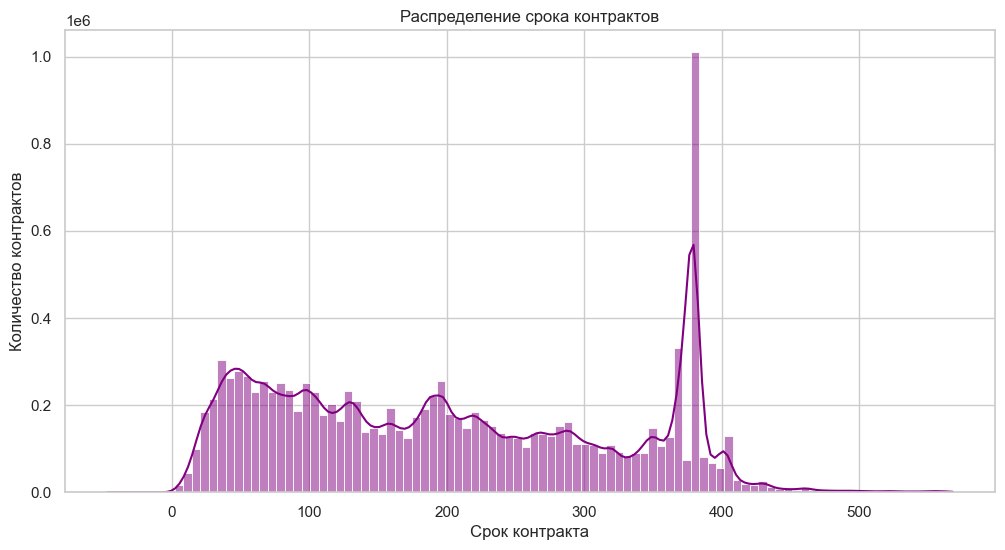

In [21]:
# Установка стиля
sns.set_style("whitegrid")

# Визуализация распределения срока контрактов
plt.figure(figsize=(12, 6))
sns.histplot(df['Срок'], bins=100, kde=True, color='purple')
plt.title('Распределение срока контрактов')
plt.xlabel('Срок контракта')
plt.ylabel('Количество контрактов')

# Сохраняем графики
plt.savefig(PHOTO_FOLDER + 'Сроки.jpeg')
plt.show()

Это не выброс, сроки контрактов зачастую составляют год, что и наблюдаем на графике

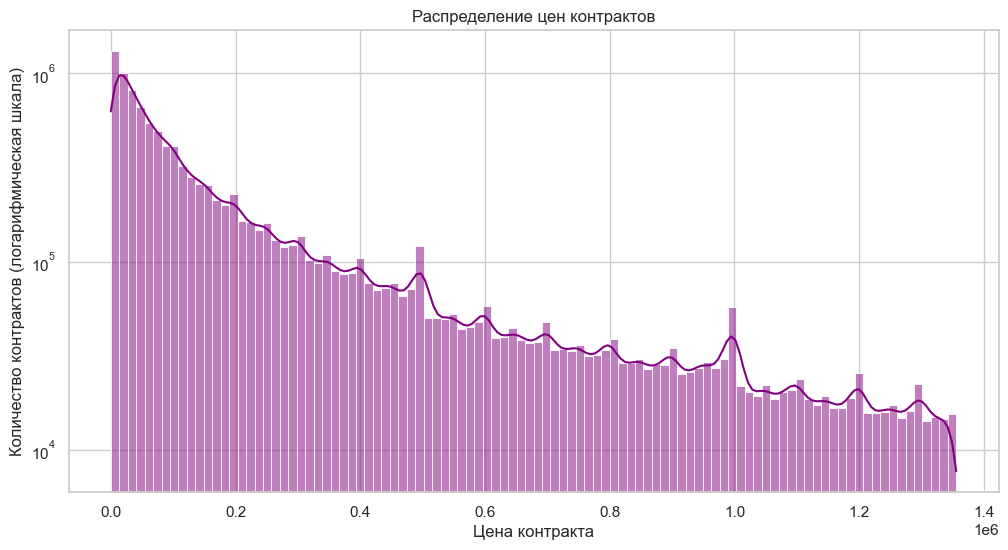

In [22]:
# Визуализация распределения цен контрактов
plt.figure(figsize=(12, 6))
sns.histplot(df['Цена контракта'], bins=100, kde=True, color='purple')
plt.yscale('log')  # Логарифмическая шкала для лучшей визуализации
plt.title('Распределение цен контрактов')
plt.xlabel('Цена контракта')
plt.ylabel('Количество контрактов (логарифмическая шкала)')

plt.savefig(PHOTO_FOLDER + 'Цены.jpeg')
plt.show()

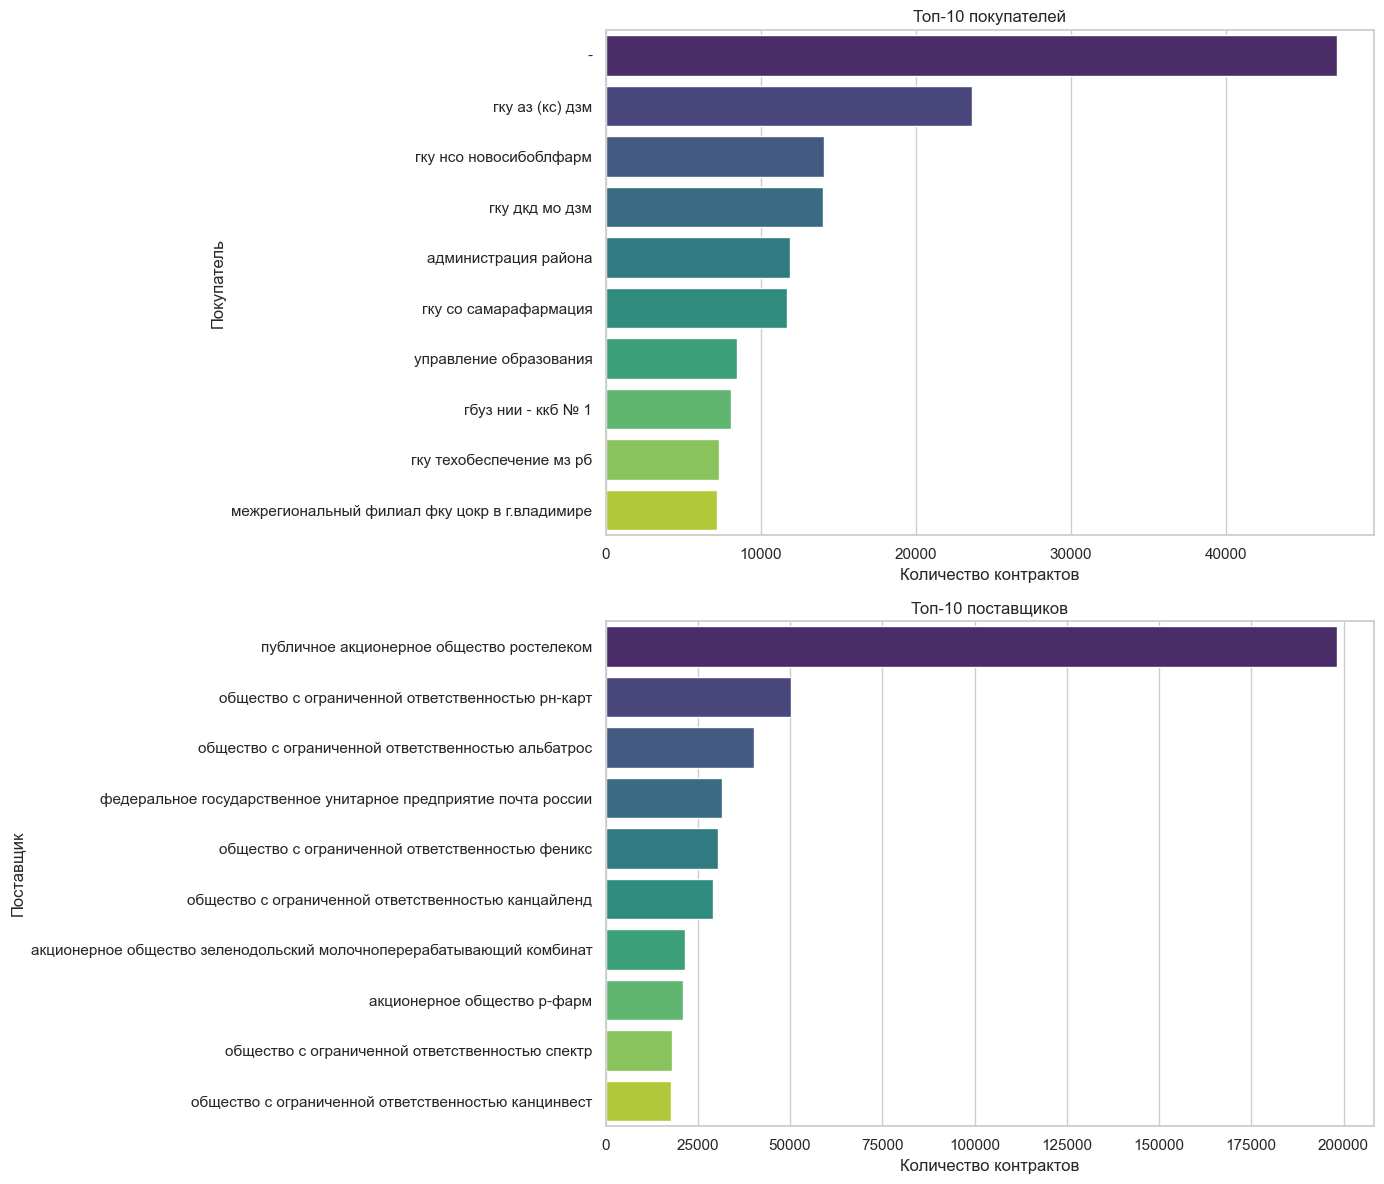

In [23]:
# Топ-10 покупателей и поставщиков
top_buyers = df['Заказчик'].value_counts().head(10)
top_suppliers = df['Исполнитель'].value_counts().head(10)

fig, ax = plt.subplots(2, 1, figsize=(14, 12))

# Топ-10 покупателей
sns.barplot(y=top_buyers.index, x=top_buyers.values, ax=ax[0], palette="viridis")
ax[0].set_title('Топ-10 покупателей')
ax[0].set_xlabel('Количество контрактов')
ax[0].set_ylabel('Покупатель')

# Топ-10 поставщиков
sns.barplot(y=top_suppliers.index, x=top_suppliers.values, ax=ax[1], palette="viridis")
ax[1].set_title('Топ-10 поставщиков')
ax[1].set_xlabel('Количество контрактов')
ax[1].set_ylabel('Поставщик')

plt.tight_layout()

plt.savefig(PHOTO_FOLDER + 'Контрагенты.jpeg')
plt.show()

Часто заказчик не указан. Это может говорить о внутренних работах

Также наиболее частый исполнитель - ростелеком. Это тоже может дать помощь при составлении моделей

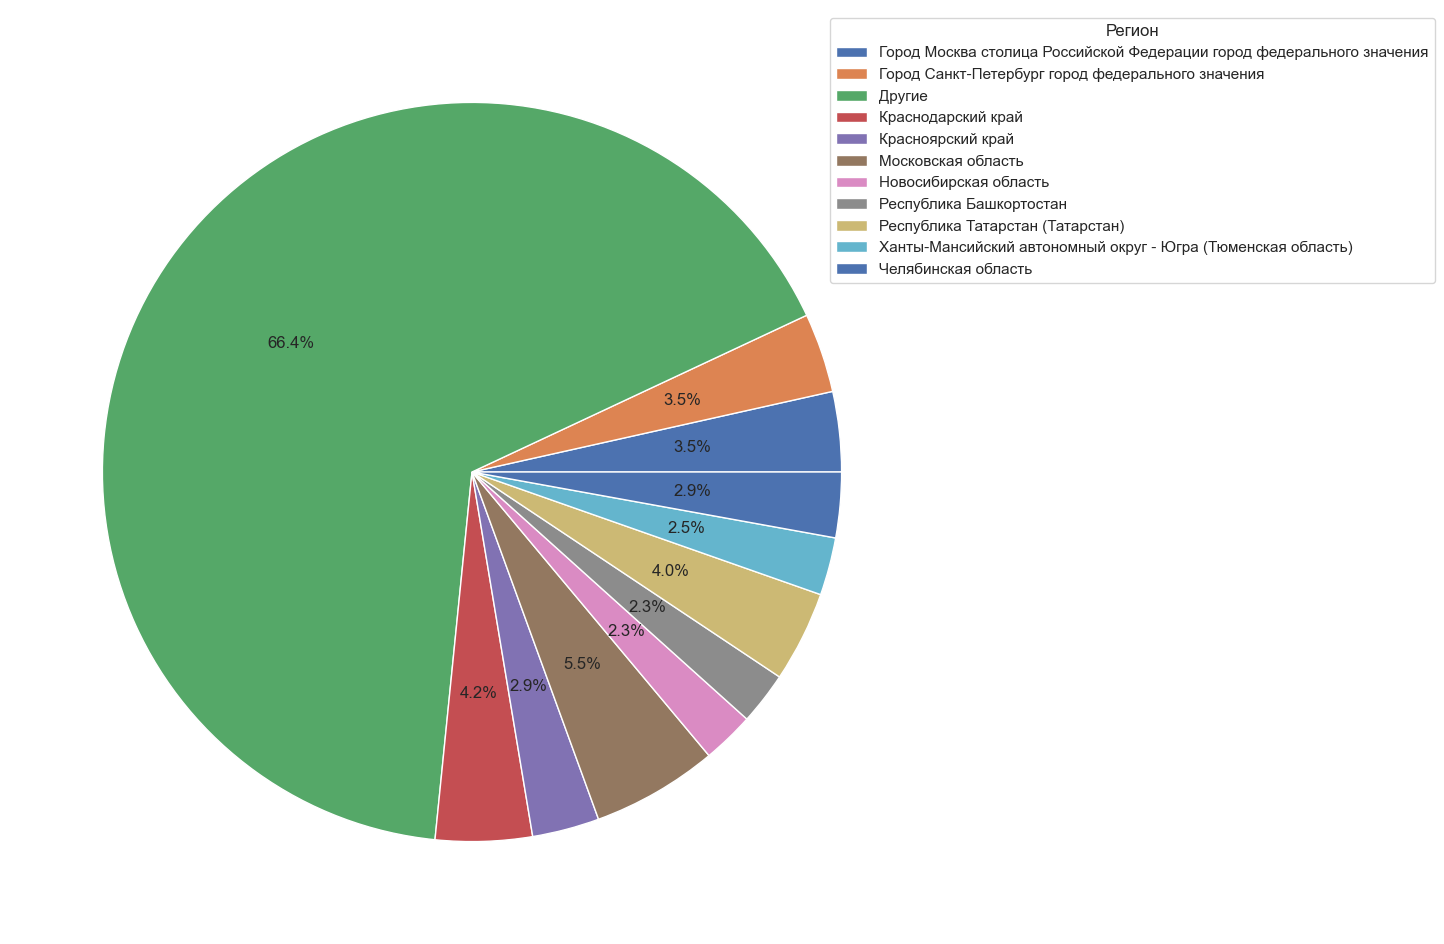

In [24]:
# Распределение контрактов по регионам
region_distribution = df['Район'].value_counts()
main_distr = list(region_distribution.head(10).index)

# Заменяем значения, которые не входят в main_distr, на "Другие"
region_distribution_demo = region_distribution.copy()
region_distribution_demo.index = region_distribution_demo.index.where(region_distribution_demo.index.isin(main_distr), 'Другие')

# Объединяем все "Другие" в одно значение
regions = region_distribution_demo.groupby(region_distribution_demo.index).sum()

# Подписи для легенды 
labels = regions.index

# График
regions.plot.pie(figsize=(12, 12),
                 autopct='%1.1f%%',
                 labels=None)

# loc - расположение
# bbox_to_anchor - расположение относительно самого графика по оси x, y
plt.legend(title='Регион', loc='upper right',
           labels=labels, bbox_to_anchor=(1.55, 1))

# Уберем подписи у самого графика
plt.ylabel(None);

# Сохраняем без обрезания, чтобы влезла легенда
plt.savefig(PHOTO_FOLDER + 'Регионы.jpeg', bbox_inches='tight')
plt.show();

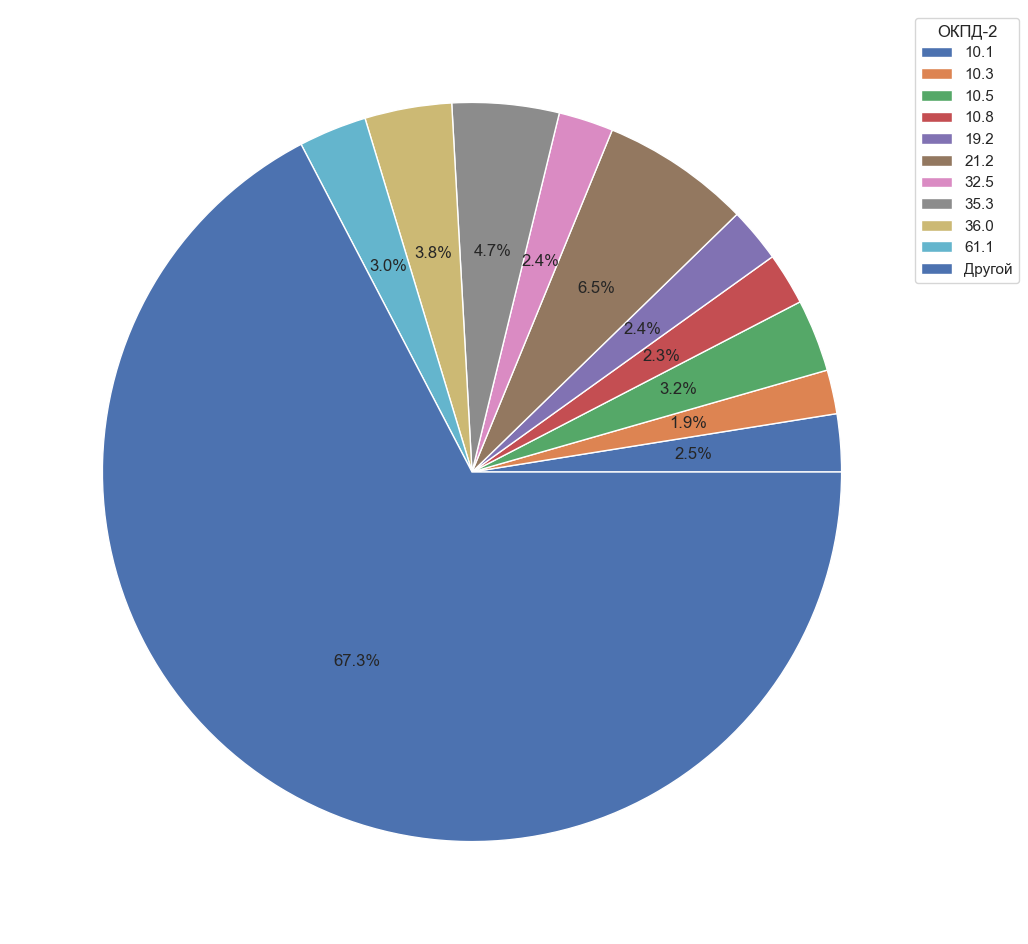

In [25]:
# Распределение кодов
region_distribution = df['y'].value_counts()
main_distr = list(region_distribution.head(10).index)

region_distribution_demo = region_distribution.copy()
region_distribution_demo.index = region_distribution_demo.index.where(region_distribution_demo.index.isin(main_distr), 'Другой')

regions = region_distribution_demo.groupby(region_distribution_demo.index).sum()

labels = regions.index

# График
regions.plot.pie(figsize=(12, 12),
                 autopct='%1.1f%%',
                 labels=None)

# loc - расположение
# bbox_to_anchor - расположение относительно самого графика по оси x, y
plt.legend(title='ОКПД-2', loc='upper right',
           labels=labels, bbox_to_anchor=(1.1, 1))

# Уберем подписи у самого графика
plt.ylabel(None);

plt.savefig(PHOTO_FOLDER + 'ОКПД-2.jpeg', bbox_inches='tight')
plt.show();

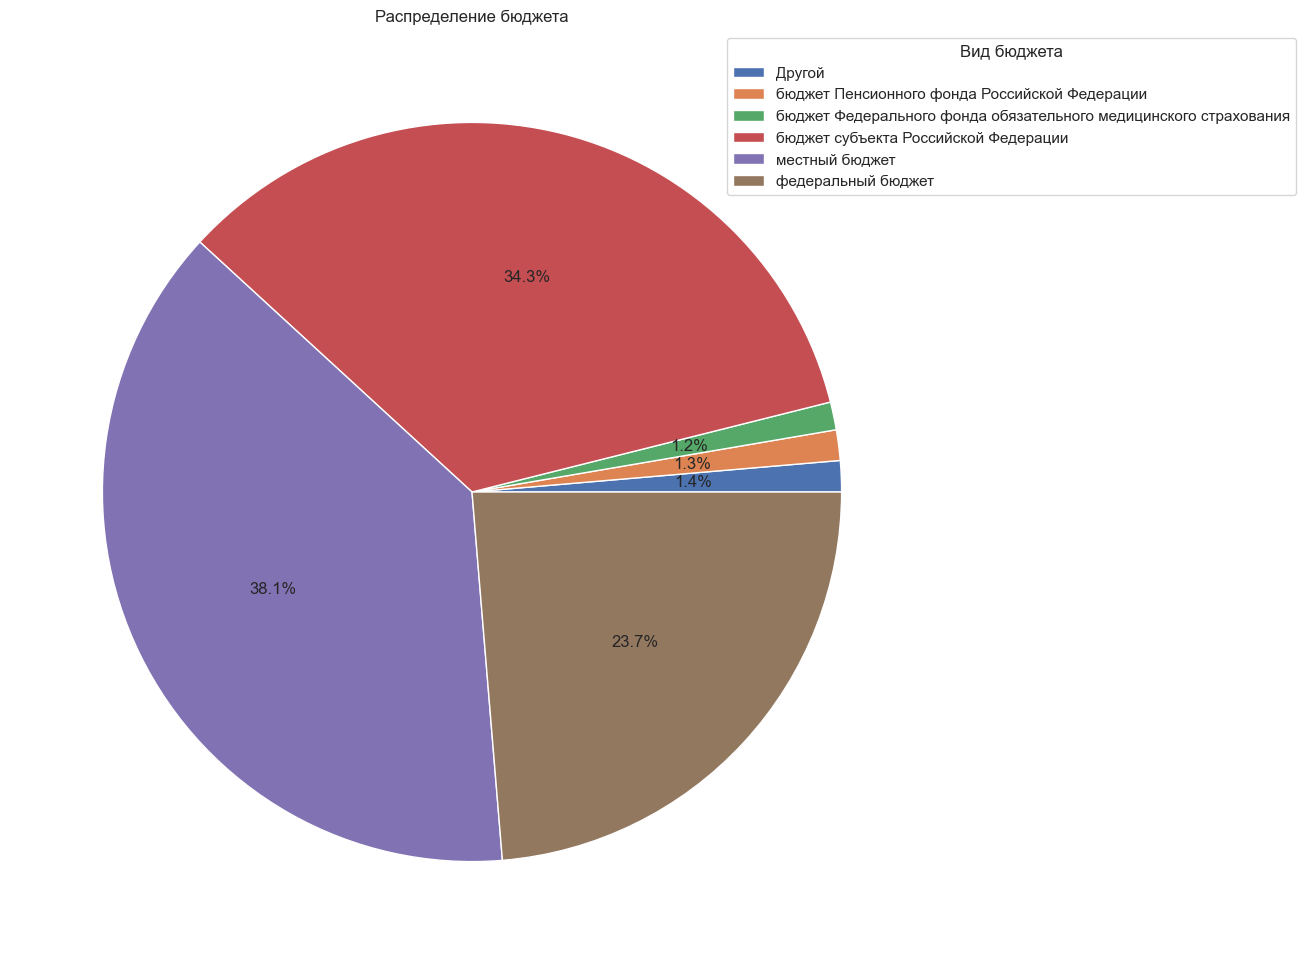

In [26]:
# Распределение кодов
budget = df['Тип бюджета'].value_counts()
main_budget = list(budget.head(5).index)

budget_d = budget.copy()
budget_d.index = budget_d.index.where(budget_d.index.isin(main_budget), 'Другой')

budget = budget_d.groupby(budget_d.index).sum()

labels = budget.index

# График
budget.plot.pie(figsize=(12, 12),
                title='Распределение бюджета',
                autopct='%1.1f%%',
                labels=None)

# loc - расположение
# bbox_to_anchor - расположение относительно самого графика по оси x, y
plt.legend(title='Вид бюджета', loc='upper right',
           labels=labels, bbox_to_anchor=(1.4, 1))

# Уберем подписи у самого графика
plt.ylabel(None);

plt.savefig(PHOTO_FOLDER + 'Виды бюджета.jpeg', bbox_inches='tight')
plt.show();

Видим ярко выраженные группы бюджетов.

В дальнейшем это может пригодиться, т.к. разные бюджеты распределяются на разные задачи.

## NLP

В данном блоке исследуем текстовые поля данных

### Длина текста

In [27]:
df['Длина описания'] = df['Заказ'].apply(len)

In [28]:
df['Длина описания'].describe()

count    1.163851e+07
mean     8.213641e+01
std      7.147015e+01
min      1.000000e+00
25%      3.300000e+01
50%      5.800000e+01
75%      1.070000e+02
max      2.000000e+03
Name: Длина описания, dtype: float64

Тоже видны выбросы и без гарфика. Возьмем также межквартильный размах. Буфер аналогичный

In [29]:
buffer = 1.3

# Рассчитываем IQR для столбца "Цена контракта"
Q1_len = df['Длина описания'].quantile(0.25)
Q3_len = df['Длина описания'].quantile(0.75)
IQR_len = Q3_len - Q1_len

# Устанавливаем границы для отсечения данных
lower_bound_len = Q1_len - buffer * IQR_len
upper_bound_len = Q3_len + buffer * IQR_len

# Фильтруем данные
df = df[
    (df['Длина описания'] >= lower_bound_len) & (df['Длина описания'] <= upper_bound_len)
]

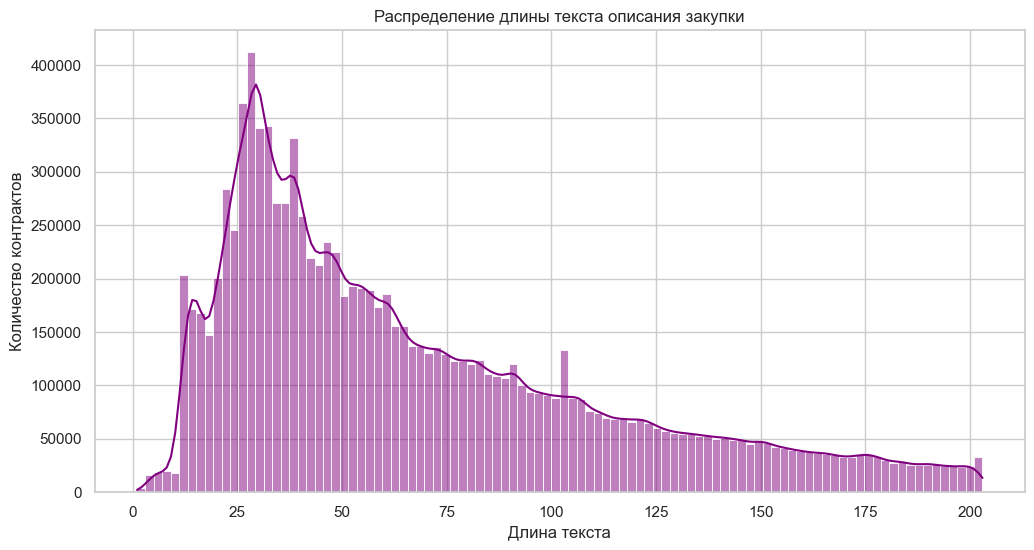

In [30]:
# Анализ длины текста описания закупки
plt.figure(figsize=(12, 6))

sns.histplot(df['Длина описания'], bins=100, kde=True, color='purple')
plt.title('Распределение длины текста описания закупки')
plt.xlabel('Длина текста')
plt.ylabel('Количество контрактов')

plt.savefig(PHOTO_FOLDER + 'Описание.jpeg')
plt.show()

На графике представлено распределение длины текста описания закупки. 

Большинство описаний имеют длину в диапазоне от 0 до 200 символов.

Тип распределения: гамма, пик 30-35 символов.

Это может говорить о натуральности описаний, т.к. короткие описания встречаются чаще.

### Частота слов

In [31]:
# Загрузка стоп-слов
stop_words = stopwords.words('russian')

In [32]:
# Функция для предварительной обработки текста
def preprocess_text(text):
    # Преобразование в нижний регистр
    text = text.lower()
    # Удаление пунктуации
    text = re.sub(r'[^\w\s]', '', text)
    # Токенизация
    tokens = word_tokenize(text)
    # Удаление стоп-слов и чисел
    tokens = [token for token in tokens if token not in stop_words and not token.isdigit()]
    return tokens

In [33]:
# Предварительная обработка текста описания закупки
df['cleaned_text'] = df['Заказ'].apply(preprocess_text)

In [34]:
# Подсчет частотности слов
word_freq = defaultdict(int)
for tokens in tqdm(df['cleaned_text']):
    for token in tokens:
        word_freq[token] += 1

# Топ-20 наиболее часто встречающихся слов
sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
top_words = sorted_word_freq[:20]
top_words_df = pd.DataFrame(top_words, columns=["Word", "Frequency"])

top_words_df

100%|██████████| 10876455/10876455 [00:17<00:00, 623313.84it/s]


,Word,Frequency
0,поставка,5039228
1,услуг,1575832
2,оказание,1505351
3,нужд,1206204
4,питания,1117719
5,продуктов,993717
6,услуги,867433
7,товаров,607641
8,области,490037
9,района,470900


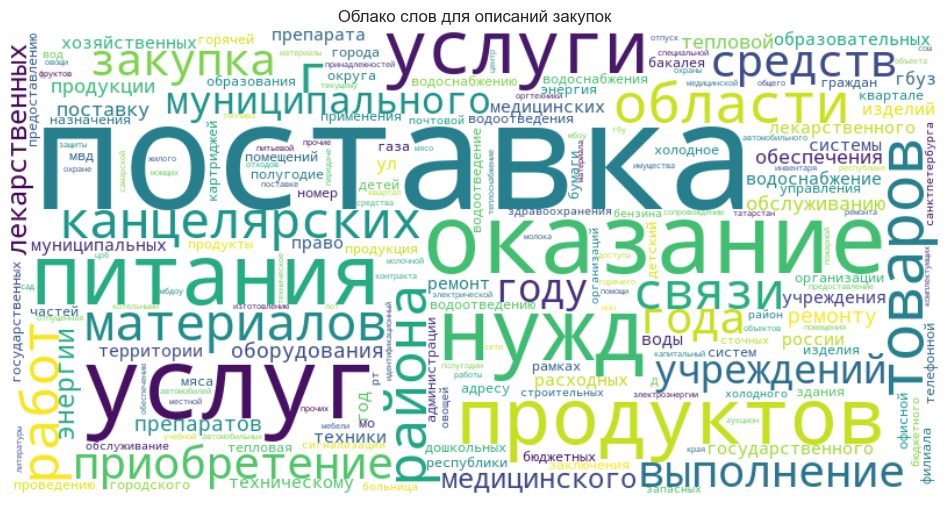

In [35]:
# Генерация облака слов
wordcloud = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(word_freq)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов для описаний закупок')

plt.savefig(PHOTO_FOLDER + 'Частота.jpeg')
plt.show()

# Распределение в группы

На данном этапе произведем распределение в группы

**Исходные группы ОКПД-2:**

По условию: 

* Строительно-монтажные работы (СМР) - 41, 42, 43

* Проектно-изыскательские работы (ПИР) - 41.1, 71.1

* Подключение коммуникаций - 43.22

* Строительный надзор – четкой группы нет.

UPD: Исправим группу - 43.2 также включает 43.22, но 43.22 в исходном датасете нет. Подтвердим это

Даже в файле с примером нет такого кода

In [36]:
df[df['y'] == '43.22']['y'].count()

0

Вывод - такой группы в датасете нет. Возьмем за основу 43.2

Подтверждение группы [здесь](https://classifikators.ru/okpd/43.2)

In [37]:
# Функция для группировки контрактов на основе ОКПД-2
def group_by_okpd(okpd):
    if okpd.startswith('41') and not okpd == '41.1':
        return 'Строительно-монтажные работы (СМР)'
    elif okpd.startswith('42'):
        return 'Строительно-монтажные работы (СМР)'
    elif okpd == ('43.2'):
        return 'Подключение коммуникаций'
    elif okpd.startswith('43'):
        return 'Строительно-монтажные работы (СМР)'
    elif okpd in ['41.1', '71.1']:
        return 'Проектно-изыскательские работы (ПИР)'
    else:
        return 'Прочее'

# Функция для получения всех форм слова
def get_word_forms(word):
    p = morph.parse(word)[0]
    forms = set()
    for inflected in p.lexeme:
        forms.add(inflected.word)
    return forms

In [38]:
# Применение функции группировки к данным
df['Группа по ОКПД'] = df['y'].apply(group_by_okpd)

In [39]:
grouped_counts = df['Группа по ОКПД'].value_counts()

grouped_counts

Группа по ОКПД
Прочее                                  10247570
Строительно-монтажные работы (СМР)        388567
Подключение коммуникаций                  149919
Проектно-изыскательские работы (ПИР)       90399
Name: count, dtype: int64

Теперь из группы "Прочее" отберем те контракты, которые могут подходить в группу "Строительный контроль"

In [40]:
# Возможные слова
supervision_words = ['надзор', 'испытания',
                     'экспертиза', 
                     'ревизия', 'аудит', 'сертификация',
                     'мониторинг', 'валидация']

In [41]:
morph = pymorphy2.MorphAnalyzer()

# Получение всех форм для каждого ключевого слова
all_forms = set()
for word in supervision_words:
    all_forms.update(get_word_forms(word))

In [42]:
# Проверяем, содержит ли описания контрактов ключевые слова (во всех их формах)
supervision_indices = df['cleaned_text'].apply(lambda x: any(form in x for form in all_forms))

# Получаем индексы контрактов, которые соответствуют условиям строительного надзора
supervision_contracts = df[supervision_indices].index

In [43]:
# Комбинированное условие: группа "Прочее" и наличие ключевых слов
condition = (df['Группа по ОКПД'] == 'Прочее') & df['cleaned_text'].apply(lambda x: any(form in x for form in all_forms))

# Получаем индексы контрактов, которые соответствуют условиям строительного надзора
supervision_contracts = df[condition].index

In [44]:
df.loc[supervision_contracts]['y'].value_counts()

y
71.2    16219
84.2     2430
33.1     2008
86.9     1795
80.1     1790
        ...  
98.2        1
23.7        1
2.2         1
23.2        1
16.1        1
Name: count, Length: 192, dtype: int64

Т.к. код 71.1 занят для другой категории, берем код 71.2 в качестве кода для строительного надзора

In [45]:
df.loc[supervision_contracts, 'Группа по ОКПД'] = 'Строительный надзор'

In [46]:
grouped_counts = df['Группа по ОКПД'].value_counts()

grouped_counts

Группа по ОКПД
Прочее                                  10200835
Строительно-монтажные работы (СМР)        388567
Подключение коммуникаций                  149919
Проектно-изыскательские работы (ПИР)       90399
Строительный надзор                        46735
Name: count, dtype: int64

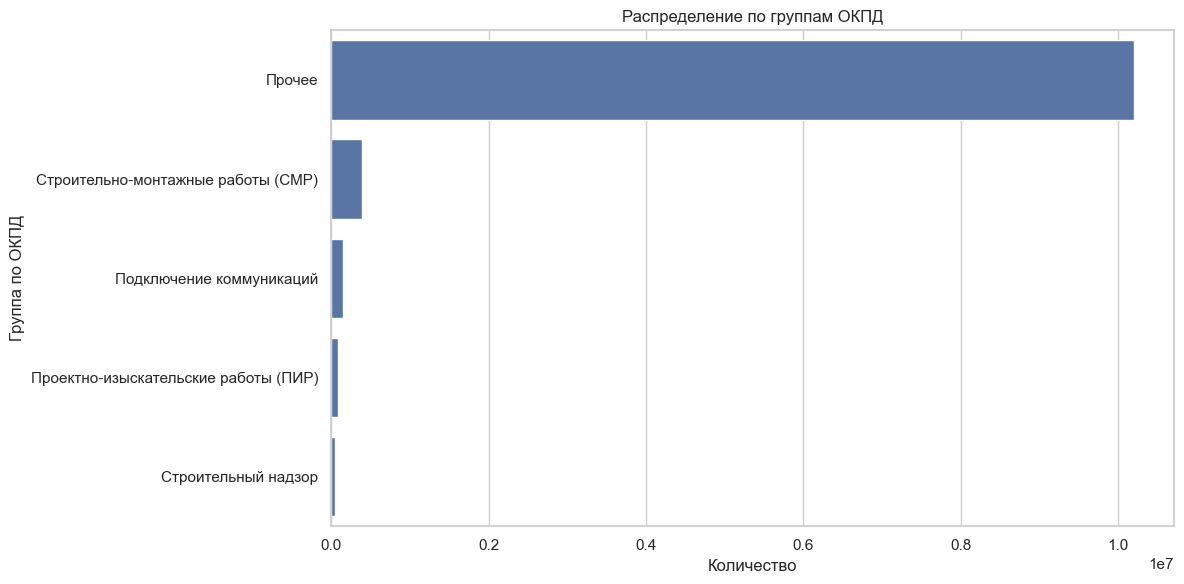

In [47]:
# График распределения по группам ОКПД
plt.figure(figsize=(12, 6))
sns.countplot(data=df, y='Группа по ОКПД', order=df['Группа по ОКПД'].value_counts().index)
plt.title('Распределение по группам ОКПД')
plt.xlabel('Количество')
plt.tight_layout()

# Сохранение графика в файл
plt.savefig(PHOTO_FOLDER + 'Группа ОКПД.jpeg')

plt.show()

Имеем большое количество примеров, поэтому дисбаланс классов пока не страшен. Сохраним результируюший Dataframe

In [48]:
df.iloc[0].T

Исполнитель          общество с ограниченной ответственностью круст
Заказчик          гу-ро фонда социального страхования российской...
Район                                    Республика Адыгея (Адыгея)
Заказ             На поставку специальных устройств для чтения «...
Тип бюджета       бюджет Фонда социального страхования Российско...
Цена контракта                                             281119.6
Описание y        Оборудование компьютерное, электронное и оптич...
y                                                              26.4
Срок                                                            310
Длина описания                                                  126
cleaned_text      [поставку, специальных, устройств, чтения, гов...
Группа по ОКПД                                               Прочее
Name: 0, dtype: object

In [49]:
df[['Исполнитель', 'Заказчик', 'Заказ',
    'Описание y', 'Группа по ОКПД', 'y']].to_csv('datasets/step_2.csv', index=False, header=True)